In [1]:
#导入表格数据
import pandas as pd
df=pd.read_excel('C:\\Users\\hp\\Desktop\\keshe\\material embedding.xlsx')

In [2]:
df.rename(columns={'voltage': 'Voltage'}, inplace=True)
df.rename(columns={'electrolyte_flow_anolyte_rate': 'Electrolyte flow rate'}, inplace=True)
df.rename(columns={'CO2_flow_rate': 'CO₂ flow rate'}, inplace=True)
df.rename(columns={'MEA_area': 'MEA area'}, inplace=True)
df.rename(columns={'membrane_area': 'Membrane area'}, inplace=True)
df.rename(columns={'anode_area': 'Anode area'}, inplace=True)
df.rename(columns={'anode_catalyst_loading': 'Anode catalyst loading'}, inplace=True)
df.rename(columns={'cathode_area': 'Cathode area'}, inplace=True)
df.rename(columns={'cathode_catalyst_loading': 'Cathode catalyst loading'}, inplace=True)
df.rename(columns={'temperature': 'Temperature'}, inplace=True)
df.rename(columns={'electrolyte_1': 'Electrolyte concentration'}, inplace=True)
df.rename(columns={'copper_containing': 'Copper containing'}, inplace=True)

In [3]:
# J列

编码值: 0 对应原始值: C2H4
编码值: 1 对应原始值: C2H5OH
编码值: 2 对应原始值: CH3COOH
编码值: 3 对应原始值: CH3OH
编码值: 4 对应原始值: CH4
编码值: 5 对应原始值: CO
编码值: 6 对应原始值: H2C2O4
编码值: 7 对应原始值: HCOOH
Average Accuracy on KFold: 0.8424675324675324
Average Precision on KFold: 0.8655429869162731
Average Recall on KFold: 0.8424675324675324
Average F1 Score on KFold: 0.8321530047945235


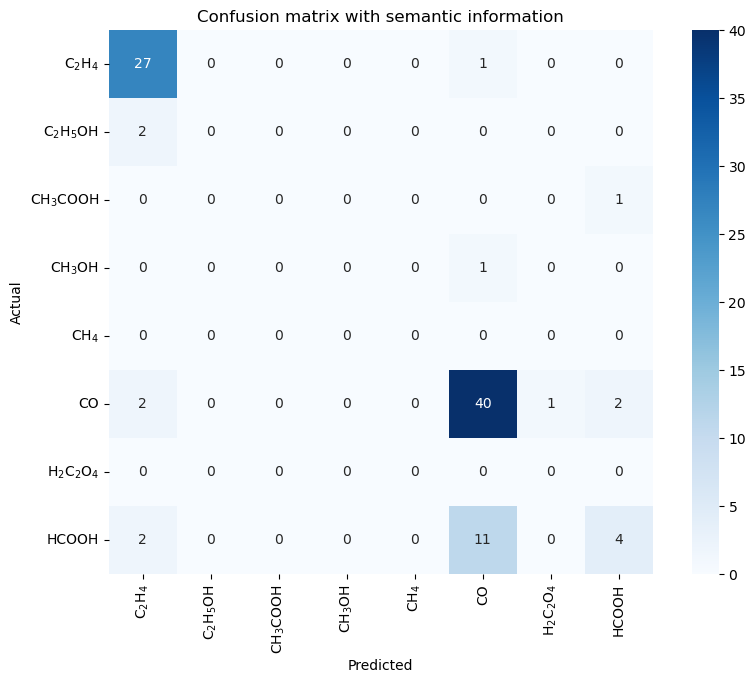

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap

bool_column = ['Copper containing']

# 定义特征列和目标列
X = df[bool_column + ['Voltage', 'Electrolyte flow rate', 'CO₂ flow rate', 'MEA area', 'Membrane area', 'Anode area',
                      'Anode catalyst loading', 'Cathode area',
                      'Cathode catalyst loading', 'Temperature', 'Electrolyte concentration']]
y = df['first_product']

# 对目标列进行编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# 获取编码后的数字和原始元素的对应关系
encoded_to_original = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# 打印对应关系
for encoded_value, original_value in encoded_to_original.items():
    print(f"编码值: {encoded_value} 对应原始值: {original_value}")

# 划分训练集和测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_encoded, train_size=0.75, test_size=0.25, random_state=42)
# K 折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_index, test_index in kf.split(X_trainval):
    X_train, X_test_fold = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_test_fold = y_trainval[train_index], y_trainval[test_index]

    # 创建随机森林分类器
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # 在训练集上进行训练
    rf_classifier.fit(X_train, y_train)

    # 在测试集上进行预测
    y_pred_fold = rf_classifier.predict(X_test_fold)

    # 计算评估指标
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted', zero_division=1)
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted', zero_division=1)
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted', zero_division=1)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# 打印平均评估指标
print(f"Average Accuracy on KFold: {np.mean(accuracies)}")
print(f"Average Precision on KFold: {np.mean(precisions)}")
print(f"Average Recall on KFold: {np.mean(recalls)}")
print(f"Average F1 Score on KFold: {np.mean(f1_scores)}")

# 在测试集上评估并绘制混淆矩阵
y_pred_test = rf_classifier.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

# 获取所有可能的标签
all_labels = label_encoder.classes_

# 定义一个函数将普通化学式字符串转换为 LaTeX 格式
def convert_to_latex(formula):
    import re
    # 匹配数字并在前面添加 _ 以实现下标
    return re.sub(r'(\d+)', r'$_{\1}$', formula)

# 将所有标签转换为 LaTeX 格式
latex_labels = [convert_to_latex(label) for label in all_labels]

# 创建一个全 0 的 DataFrame，索引和列名为所有可能的标签
conf_matrix_df = pd.DataFrame(0, index=latex_labels, columns=latex_labels)

# 填充实际的混淆矩阵值
for true_encoded, pred_encoded in zip(y_test, y_pred_test):
    true_label = label_encoder.inverse_transform([true_encoded])[0]
    pred_label = label_encoder.inverse_transform([pred_encoded])[0]
    true_latex_label = convert_to_latex(true_label)
    pred_latex_label = convert_to_latex(pred_label)
    conf_matrix_df.loc[true_latex_label, pred_latex_label] += 1

# 绘制混淆矩阵的热力图
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', square=True)
# 设置 x 轴标签旋转 90 度，变为纵向显示
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# 设置 y 轴标签旋转 0 度，变为横向显示
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.gcf().subplots_adjust(bottom=0.2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix with semantic information')
plt.savefig('J仅数值混淆矩阵.jpg', dpi=3000)
plt.show()

In [5]:
# K列

In [6]:
df.rename(columns={'first_product_faraday_efficiency': 'First product faraday efficiency'}, inplace=True)
df['First product faraday efficiency'] = df['First product faraday efficiency'] / 100
print(df['First product faraday efficiency'])

0      0.9300
1      0.9100
2      0.3400
3      0.9330
4      0.8200
        ...  
368    0.4482
369    0.9220
370    0.9864
371    0.9000
372    0.4390
Name: First product faraday efficiency, Length: 373, dtype: float64


Random Forest - Average Mean Squared Error: 0.029794590443483156
Random Forest - Average Coefficient of determination: 0.5067756042437741
随机森林拟合直线方程为：y = 0.57931x + 0.26684
随机森林模型的R2值为：0.50678


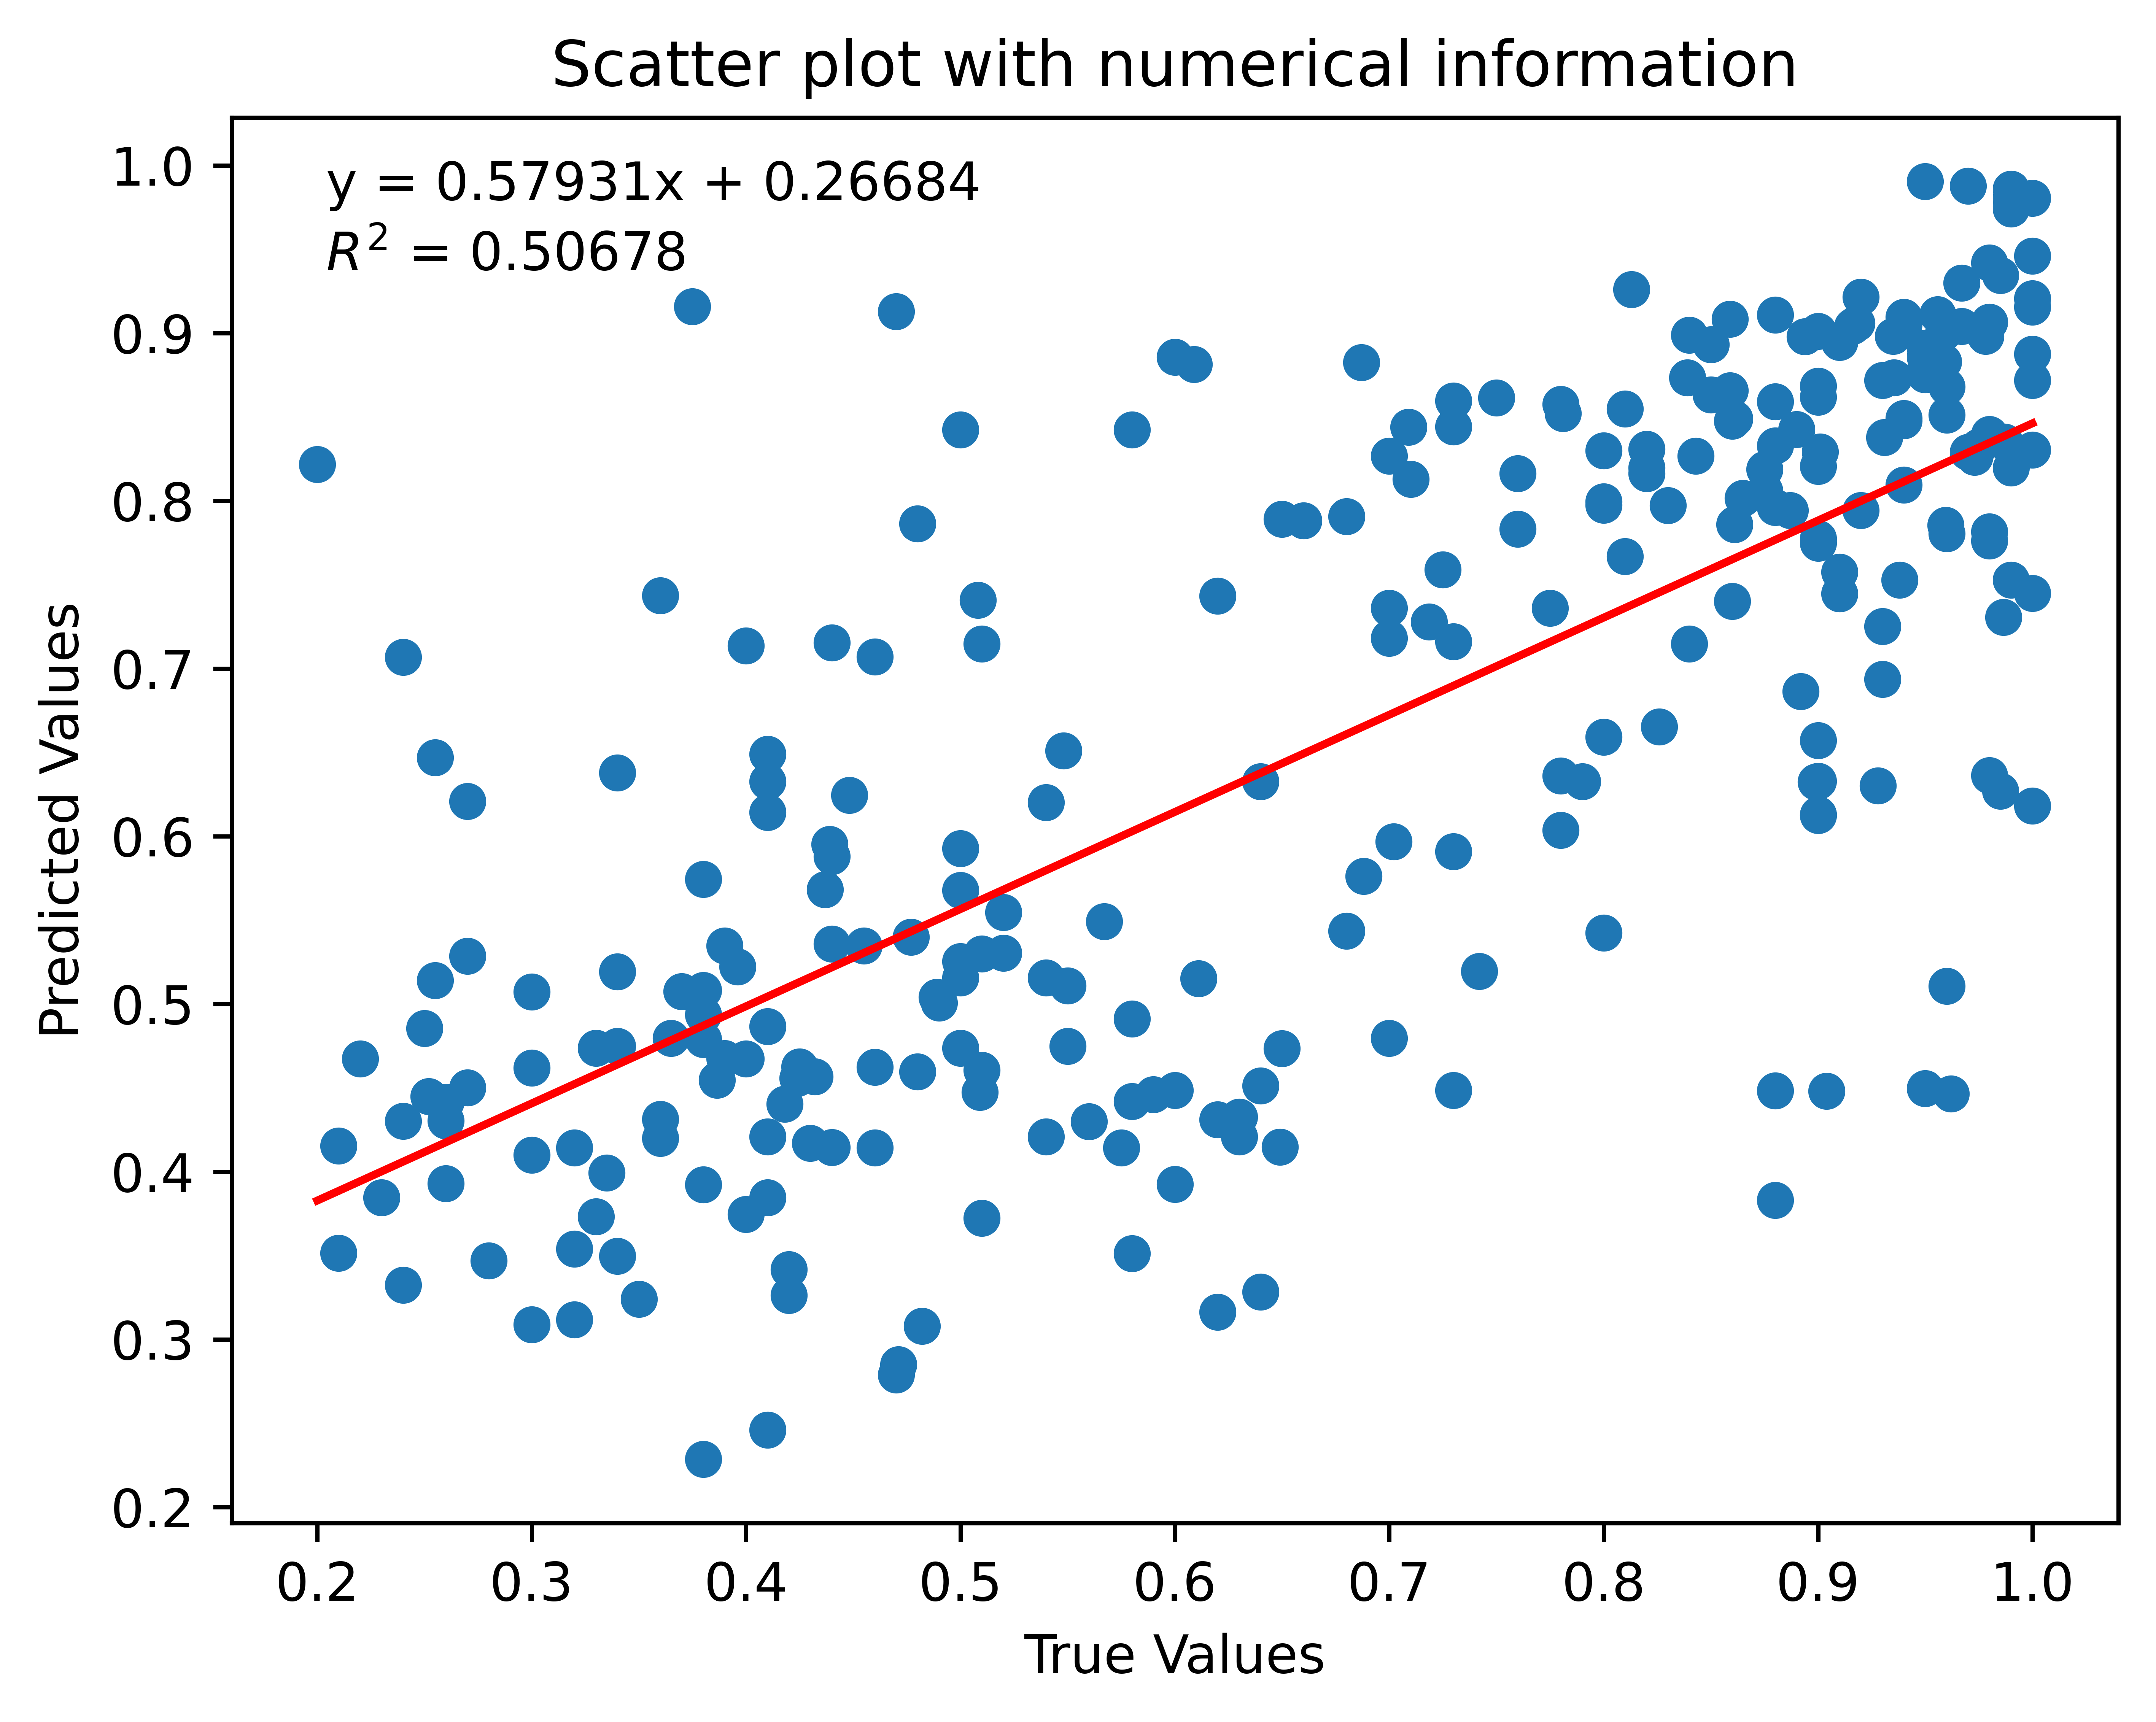

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

bool_column = ['Copper containing']

# 定义特征列和目标列
X = df[bool_column + ['Voltage', 'Electrolyte flow rate', 'CO₂ flow rate',
                      'MEA area', 'Membrane area', 'Anode area',
                      'Anode catalyst loading', 'Cathode area',
                      'Cathode catalyst loading', 'Temperature', 'Electrolyte concentration']]
y = df['First product faraday efficiency']

# 划分训练集和测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=42)

# 设置matplotlib的dpi
plt.rcParams['figure.dpi'] = 1000
# 初始化K折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 用于存储随机森林模型的评估指标结果
rf_mse_scores = []
rf_r2_scores = []
all_true_values = []
all_predicted_values = []

# 随机森林回归模型
rf_model = RandomForestRegressor(random_state=42)

for train_index, val_index in kf.split(X_trainval):
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    rf_model.fit(X_train, y_train)
    y_val_pred = rf_model.predict(X_val)
    rf_mse_scores.append(mean_squared_error(y_val, y_val_pred))
    rf_r2_scores.append(r2_score(y_val, y_val_pred))
    all_true_values.extend(y_val)
    all_predicted_values.extend(y_val_pred)

# 计算平均均方误差和平均决定系数
average_mse = np.mean(rf_mse_scores)
average_r2 = np.mean(rf_r2_scores)

print(f"Random Forest - Average Mean Squared Error: {average_mse}")
print(f"Random Forest - Average Coefficient of determination: {average_r2}")

# 将收集的真实值和预测值转换为合适的numpy数组格式（二维），方便后续线性回归拟合操作
all_true_values = np.array(all_true_values).reshape(-1, 1)
all_predicted_values = np.array(all_predicted_values).reshape(-1, 1)

# 创建线性回归对象并拟合数据，目的是得到拟合直线的系数等信息
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(all_true_values, all_predicted_values)

# 获取拟合直线的斜率和截距
slope = linear_regressor.coef_[0][0]
intercept = linear_regressor.intercept_[0]

# 计算R2值
r2 = average_r2

# 输出拟合直线方程
print(f"随机森林拟合直线方程为：y = {slope:.5f}x + {intercept:.5f}")
print(f"随机森林模型的R2值为：{r2:.5f}")


# 绘制散点图
plt.scatter(all_true_values, all_predicted_values)

# 根据拟合得到的斜率和截距绘制拟合直线
x_vals = np.array([min(all_true_values), max(all_true_values)])
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red')

# 添加回归方程和R2值到图表
plt.text(0.05, 0.97, f"y = {slope:.5f}x + {intercept:.5f}", transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top')
plt.text(0.05, 0.92, f"$R^2$ = {r2:.5f}", transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter plot with numerical information')
plt.savefig('K仅数值散点图.jpg', dpi=1000)
plt.show()

In [8]:
# Q列

In [9]:
# 处理total_current_density列成为分类变量
def categorize_current(current):
    if 0 < current <= 100:
        return 'Category_1'
    elif 100 < current <= 180:
        return 'Category_2'
    elif 180 < current <= 1000:
        return 'Category_3'    
df['tcd_category'] = df['total_current_density'].apply(categorize_current)

编码值: 0 对应原始值: Category_1
编码值: 1 对应原始值: Category_2
编码值: 2 对应原始值: Category_3
Average Accuracy on KFold: 0.6453246753246753
Average Precision on KFold: 0.673866873025964
Average Recall on KFold: 0.6453246753246753
Average F1 Score on KFold: 0.6470994088479662


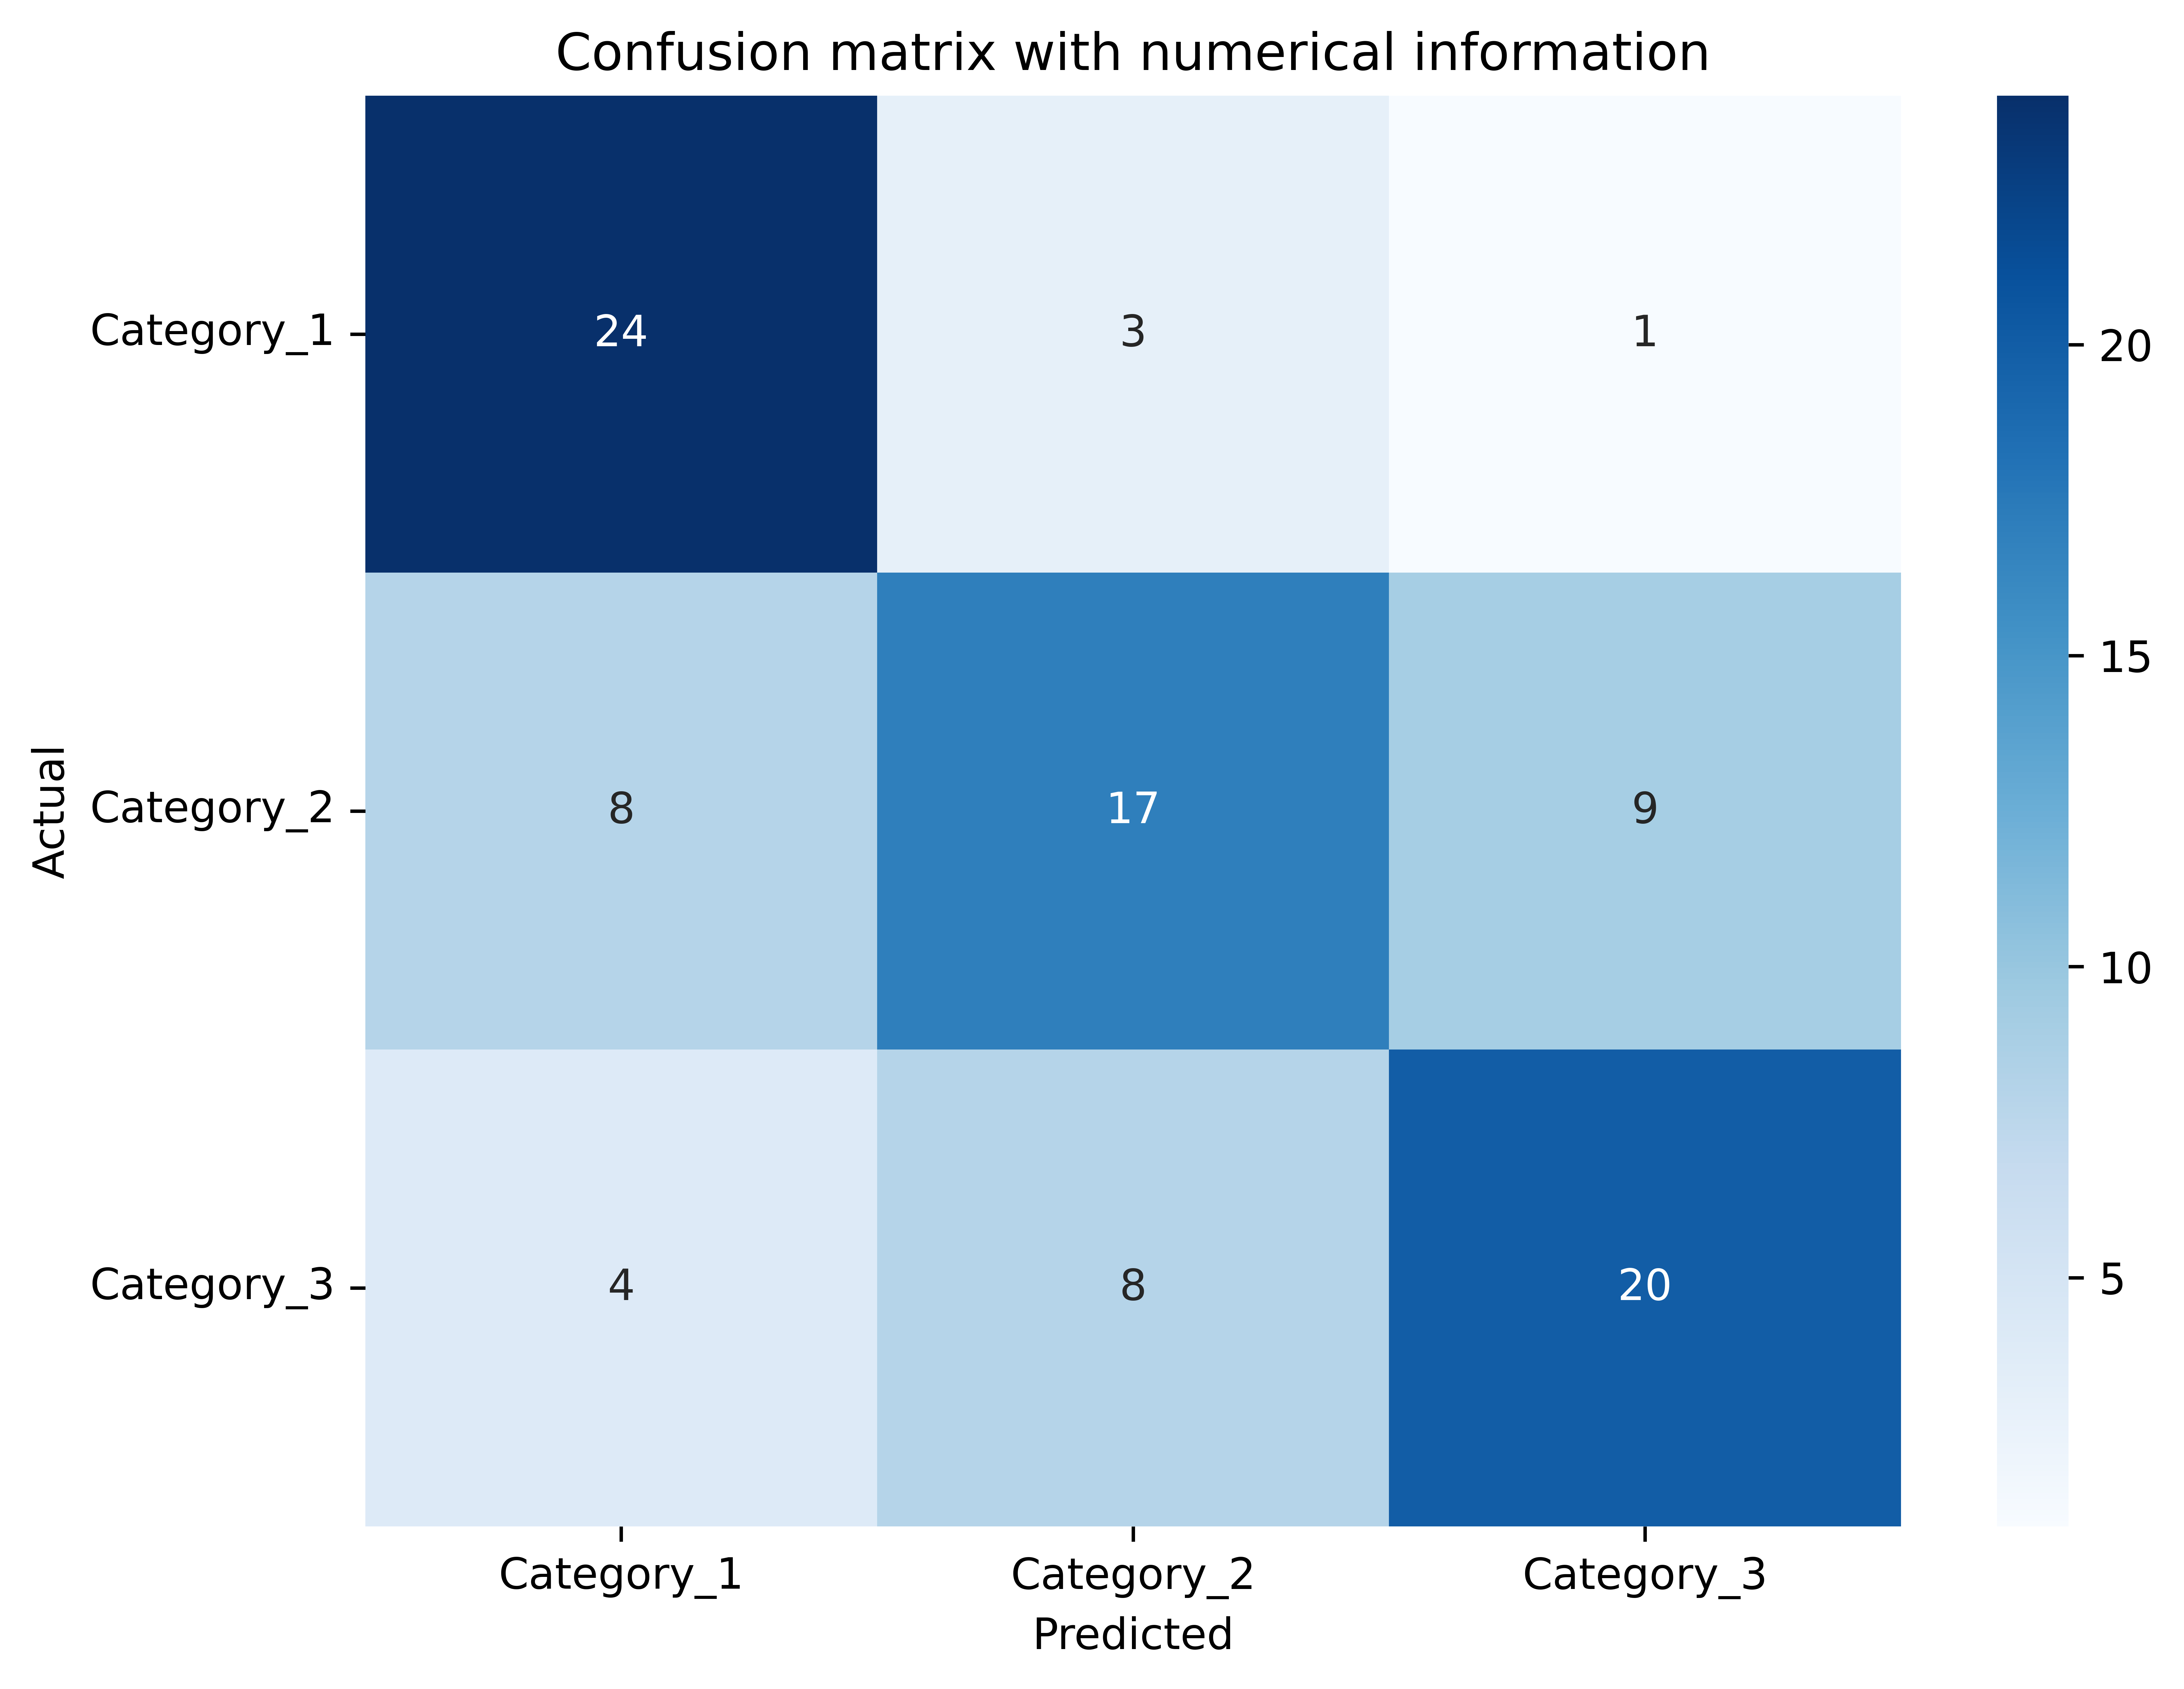

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap
bool_column = ['Copper containing']

# 定义特征列和目标列
X = df[bool_column + ['Voltage', 'Electrolyte flow rate','CO₂ flow rate',
                                                               'MEA area', 'Membrane area', 'Anode area',
                                                               'Anode catalyst loading', 'Cathode area',
                                                               'Cathode catalyst loading', 'Temperature', 'Electrolyte concentration']]
y = df['tcd_category']

# 对目标列进行编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# 获取编码后的数字和原始元素的对应关系
encoded_to_original = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# 打印对应关系
for encoded_value, original_value in encoded_to_original.items():
    print(f"编码值: {encoded_value} 对应原始值: {original_value}")
# 划分训练集和测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_encoded, train_size=0.75, test_size=0.25, random_state=42)
# 设置matplotlib的dpi
plt.rcParams['figure.dpi'] = 1000
# K 折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_index, test_index in kf.split(X_trainval):
    X_train, X_test_fold = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_test_fold = y_trainval[train_index], y_trainval[test_index]

    # 创建随机森林分类器
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # 在训练集上进行训练
    rf_classifier.fit(X_train, y_train)

    # 在测试集上进行预测
    y_pred_fold = rf_classifier.predict(X_test_fold)

    # 计算评估指标
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    precision = precision_score(y_test_fold, y_pred_fold, average='weighted',zero_division=1)
    recall = recall_score(y_test_fold, y_pred_fold, average='weighted',zero_division=1)
    f1 = f1_score(y_test_fold, y_pred_fold, average='weighted',zero_division=1)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# 打印平均评估指标
print(f"Average Accuracy on KFold: {np.mean(accuracies)}")
print(f"Average Precision on KFold: {np.mean(precisions)}")
print(f"Average Recall on KFold: {np.mean(recalls)}")
print(f"Average F1 Score on KFold: {np.mean(f1_scores)}")

# 在测试集上评估并绘制混淆矩阵
y_pred_test = rf_classifier.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

# 绘制混淆矩阵并保存为png
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion matrix with numerical information')
# 设置y轴标签水平显示
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Q仅数值混淆矩阵.jpg',dpi=1000, bbox_inches = 'tight')
plt.show()